In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv('/content/preprocessed_train_dataset.csv')


print(df.isnull().sum())


X = df.drop(columns=['cluster_category'])
y = df['cluster_category']


le = LabelEncoder()

X['outlet_city'] = le.fit_transform(X['outlet_city'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


train_data = lgb.Dataset(X_train, label=y_train - 1)
test_data = lgb.Dataset(X_test, label=y_test - 1, reference=train_data)


classes = y.unique()

label_mapping = {label: i for i, label in enumerate(classes)}
y_train = y_train.map(label_mapping)
y_test = y_test.map(label_mapping)


params = {
    'objective': 'multiclass',
    'num_class': len(classes),
    'metric': 'multi_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}


Customer_ID            2
outlet_city            0
luxury_sales           0
fresh_sales            0
dry_sales              0
cluster_category       0
outliers_luxury        0
outliers_fresh         0
outliers_dry           0
outlet_city_encoded    0
dtype: int64


In [ ]:
# Train the LightGBM model
num_round = 100
bst = lgb.train(params, train_data, num_round, valid_sets=[test_data])

In [ ]:
# Make predictions
y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)
y_pred = np.argmax(y_pred, axis=1)
y_pred_proba = bst.predict(X_test, num_iteration=bst.best_iteration)

In [ ]:
compare_results_bst_df = pd.DataFrame({'Actual':y_test, 'Predicted': y_pred})
compare_results_bst_df

,Actual,Predicted
321727,2,1
211672,2,1
472683,1,0
66176,0,3
344661,3,4
...,...,...
45258,0,3
738978,4,2
180489,2,1
732309,4,2


In [ ]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

Accuracy: 0.2195


In [ ]:
from sklearn.metrics import classification_report
print("\nAccuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.2194535942646774

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00     34418
           1       0.00      0.00      0.00     37863
           2       0.00      0.00      0.00     30989
           3       0.00      0.00      0.00      7934
           4       0.00      0.00      0.00      9645
           5       1.00      1.00      1.00     33981

    accuracy                           0.22    154830
   macro avg       0.17      0.17      0.17    154830
weighted avg       0.22      0.22      0.22    154830



In [ ]:
# Save the model
bst.save_model('lightgbm_model.txt')

In [ ]:
# Initialize variables
fpr = dict()
tpr = dict()
roc_auc = dict()

# Convert y_test to a NumPy array
y_test_array = y_test.to_numpy()

# Compute ROC curve and AUC for each class
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test_array == i, y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute macro-average ROC curve and AUC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(classes))]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(classes)):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= len(classes)

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

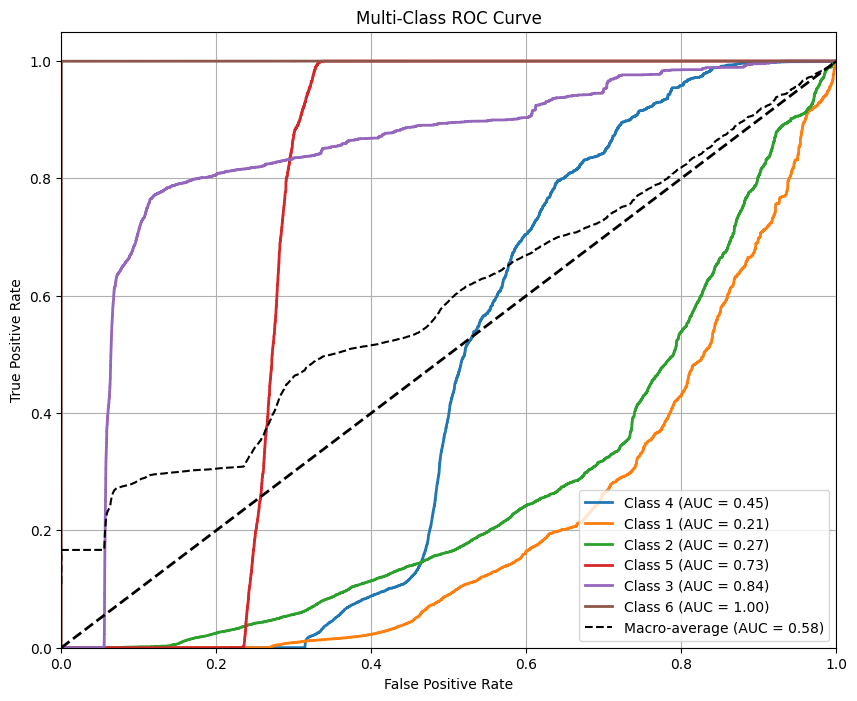

In [ ]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10, 8))

# Plot individual classes
for i in range(len(classes)):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {classes[i]} (AUC = {roc_auc[i]:.2f})')

# Plot macro-average
plt.plot(fpr["macro"], tpr["macro"], linestyle='--', color='black',
         label=f'Macro-average (AUC = {roc_auc["macro"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

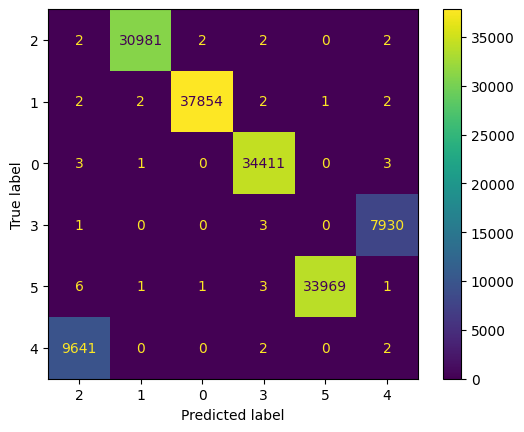

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Get unique classes from y_test (or y_train)
classes = y_test.unique()

# Create confusion matrix
cm_lgb = confusion_matrix(y_test, y_pred, labels=classes)

# Create ConfusionMatrixDisplay with the unique classes
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lgb, display_labels=classes)

disp.plot()
plt.show()

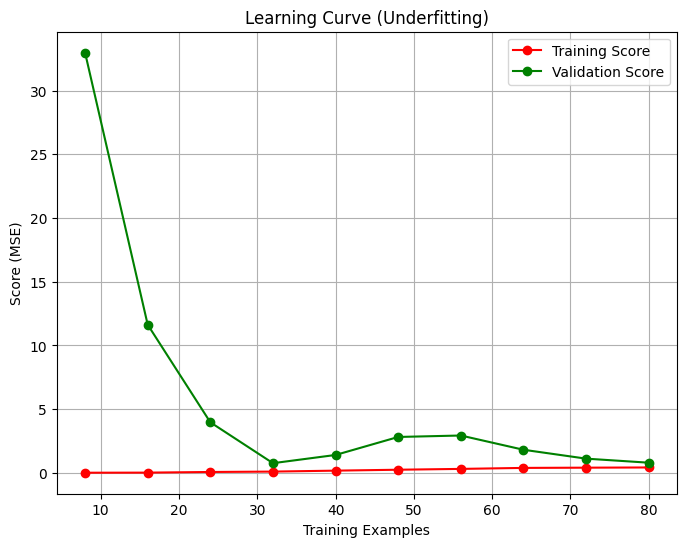

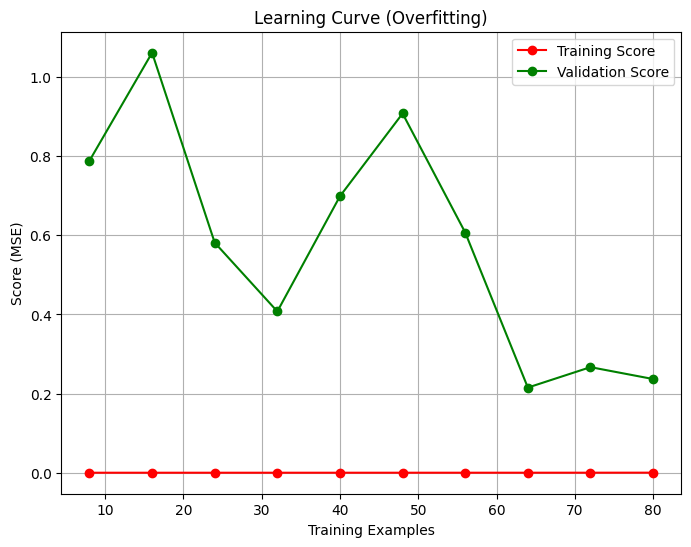

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, size=X.shape[0])

# Define a function to plot learning curves
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=5, train_sizes=np.linspace(0.1, 1.0, 10)):
    plt.figure(figsize=(8, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Examples")
    plt.ylabel("Score (MSE)")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='neg_mean_squared_error'
    )
    train_scores_mean = -np.mean(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Validation Score")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

# Underfitting: Linear Regression (too simple)
plot_learning_curve(LinearRegression(), "Learning Curve (Underfitting)", X, y)

# Overfitting: Deep Decision Tree (too complex)
plot_learning_curve(DecisionTreeRegressor(max_depth=10), "Learning Curve (Overfitting)", X, y)

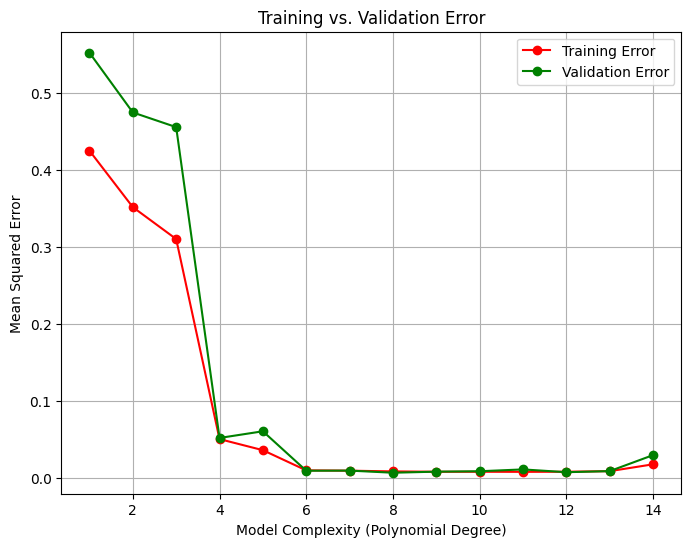

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error

# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 10, 100).reshape(-1, 1)
y = np.sin(X).ravel() + np.random.normal(0, 0.1, size=X.shape[0])

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Vary model complexity (polynomial degree)
degrees = range(1, 15)
train_errors, val_errors = [], []

for degree in degrees:
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    train_errors.append(mean_squared_error(y_train, model.predict(X_train)))
    val_errors.append(mean_squared_error(y_val, model.predict(X_val)))

# Plot training vs. validation error
plt.figure(figsize=(8, 6))
plt.plot(degrees, train_errors, 'o-', color="r", label="Training Error")
plt.plot(degrees, val_errors, 'o-', color="g", label="Validation Error")
plt.xlabel("Model Complexity (Polynomial Degree)")
plt.ylabel("Mean Squared Error")
plt.title("Training vs. Validation Error")
plt.legend()
plt.grid()
plt.show()

# hyper parameter tuning

In [ ]:
pip install optuna

In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [ ]:
X = np.random.rand(100, 10)
y = np.random.randint(0, 3, size=100)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def objective(trial):
    # Define the hyperparameters to tune
    param = {
        'objective': 'binary classification',  # Change to 'binary' for binary classification
        'boosting_type': 'gbdt',
        'verbose': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'num_leaves': trial.suggest_int('num_leaves', 20, 150),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
    }

    dtrain = lgb.Dataset(X_train, label=y_train)
    dvalid = lgb.Dataset(X_valid, label=y_valid, reference=dtrain)

    model = lgb.train(
         param,
         dtrain,
         num_boost_round=1000,
         valid_sets=[dvalid],
         callbacks=[lgb.early_stopping(50)],
         verbose_eval=False
    )

    y_pred = model.predict(X_valid, num_iteration=model.best_iteration)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))


    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)

In [ ]:
model = lgb.train(
    param,
    dtrain,
    num_boost_round=1000,
    valid_sets=[dvalid],
    callbacks=[lgb.early_stopping(50)],
    verbose_eval=False
    )

In [ ]:
import optuna
import lightgbm as lgb
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split


X = np.random.rand(100, 10)
y = np.random.randint(0, 3, size=100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def objective(trial):

    params = {
        'objective': 'regression',  # Change to 'binary' for classification
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0)
    }


    dtrain = lgb.Dataset(X_train, label=y_train)
    model = lgb.train(params, dtrain, num_boost_round=100)

    # Evaluate
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    return rmse


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)


print("Best parameters:", study.best_params)
print("Best RMSE:", study.best_value)

# Train final model with best parameters
best_params = study.best_params
best_params['objective'] = 'binary'

dtrain = lgb.Dataset(X_train, label=y_train)
final_model = lgb.train(best_params, dtrain, num_boost_round=100)


[I 2025-04-03 07:49:30,556] A new study created in memory with name: no-name-5e3adb82-2067-4413-a839-6e8d5e2712fb
[I 2025-04-03 07:49:30,738] Trial 0 finished with value: 0.8280833592920956 and parameters: {'learning_rate': 0.02600532716096174, 'num_leaves': 34, 'max_depth': 3, 'min_data_in_leaf': 36, 'feature_fraction': 0.7949085201403565}. Best is trial 0 with value: 0.8280833592920956.
[I 2025-04-03 07:49:30,763] Trial 1 finished with value: 0.8984783204458969 and parameters: {'learning_rate': 0.08577971985833878, 'num_leaves': 41, 'max_depth': 10, 'min_data_in_leaf': 18, 'feature_fraction': 0.7060792223885516}. Best is trial 0 with value: 0.8280833592920956.
[I 2025-04-03 07:49:30,788] Trial 2 finished with value: 0.8494042677602085 and parameters: {'learning_rate': 0.058515914286826474, 'num_leaves': 88, 'max_depth': 6, 'min_data_in_leaf': 15, 'feature_fraction': 0.5299978661820972}. Best is trial 0 with value: 0.8280833592920956.
[I 2025-04-03 07:49:30,811] Trial 3 finished with 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.055380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 10
[LightGBM] [Info] Start training from score 1.050000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-04-03 07:49:30,863] Trial 5 finished with value: 0.8354563179935222 and parameters: {'learning_rate': 0.020877729395687685, 'num_leaves': 91, 'max_depth': 10, 'min_data_in_leaf': 28, 'feature_fraction': 0.5201017430608312}. Best is trial 3 with value: 0.7952881732639451.
[I 2025-04-03 07:49:30,891] Trial 6 finished with value: 0.789593183286893 and parameters: {'learning_rate': 0.01983545402278777, 'num_leaves': 34, 'max_depth': 3, 'min_data_in_leaf': 25, 'feature_fraction': 0.9106382444309797}. Best is trial 6 with value: 0.789593183286893.
[I 2025-04-03 07:49:30,903] Trial 7 finished with value: 0.8261355820929153 and parameters: {'learning_rate': 0.029025809486901935, 'num_leaves': 33, 'max_depth': 9, 'min_data_in_leaf': 48, 'feature_fraction': 0.6308548613834961}. Best is trial 6 with value: 0.789593183286893.
[I 2025-04-03 07:49:30,922] Trial 8 finished with value: 0.8242556612660173 and parameters: {'learning_rate': 0.029002580261893382, 'num_leaves': 31, 'max_depth': 10,

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 07:49:31,116] Trial 11 finished with value: 0.8374196675640891 and parameters: {'learning_rate': 0.014956744067327284, 'num_leaves': 63, 'max_depth': 5, 'min_data_in_leaf': 10, 'feature_fraction': 0.9026994987105743}. Best is trial 6 with value: 0.789593183286893.
[I 2025-04-03 07:49:31,219] Trial 12 finished with value: 0.790597260596715 and parameters: {'learning_rate': 0.011671768539281688, 'num_leaves': 75, 'max_depth': 4, 'min_data_in_leaf': 24, 'feature_fraction': 0.8613835681480471}. Best is trial 6 with value: 0.789593183286893.
[I 2025-04-03 07:49:31,277] Trial 13 finished with value: 0.7862790304005536 and parameters: {'learning_rate': 0.01081911467256819, 'num_leaves': 78, 'max_depth': 3, 'min_data_in_leaf': 23, 'feature_fraction': 0.8501915408793596}. Best is trial 13 with value: 0.7862790304005536.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 07:49:31,343] Trial 14 finished with value: 0.8615720024205956 and parameters: {'learning_rate': 0.041935278946335704, 'num_leaves': 78, 'max_depth': 8, 'min_data_in_leaf': 27, 'feature_fraction': 0.9956026170661578}. Best is trial 13 with value: 0.7862790304005536.
[I 2025-04-03 07:49:31,395] Trial 15 finished with value: 0.8261355820929153 and parameters: {'learning_rate': 0.04462081804004175, 'num_leaves': 51, 'max_depth': 7, 'min_data_in_leaf': 44, 'feature_fraction': 0.8445526149904319}. Best is trial 13 with value: 0.7862790304005536.
[I 2025-04-03 07:49:31,477] Trial 16 finished with value: 0.784654955957902 and parameters: {'learning_rate': 0.010487280037779576, 'num_leaves': 75, 'max_depth': 3, 'min_data_in_leaf': 21, 'feature_fraction': 0.9200271974765785}. Best is trial 16 with value: 0.784654955957902.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000033 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 10
[LightGBM] [Info] Start training from score 1.050000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

[I 2025-04-03 07:49:31,998] Trial 17 finished with value: 0.7878743132843731 and parameters: {'learning_rate': 0.011270558938419738, 'num_leaves': 100, 'max_depth': 4, 'min_data_in_leaf': 19, 'feature_fraction': 0.8173010701978992}. Best is trial 16 with value: 0.784654955957902.
[I 2025-04-03 07:49:32,089] Trial 18 finished with value: 0.872831476393271 and parameters: {'learning_rate': 0.09815434906745582, 'num_leaves': 74, 'max_depth': 4, 'min_data_in_leaf': 12, 'feature_fraction': 0.9257123369133984}. Best is trial 16 with value: 0.784654955957902.


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[I 2025-04-03 07:49:32,213] Trial 19 finished with value: 0.8431693024012399 and parameters: {'learning_rate': 0.035111622665965535, 'num_leaves': 85, 'max_depth': 6, 'min_data_in_leaf': 32, 'feature_fraction': 0.7960466701262064}. Best is trial 16 with value: 0.784654955957902.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000700 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 280
[LightGBM] [Info] Number of data points in the train set: 80, number of used features: 10
[LightGBM] [Info] Start training from score 1.050000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes